In [1]:
!pip install torch torchvision torchaudio opencv-python matplotlib seaborn tqdm kaggle --quiet
import os

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"halimatmusa","key":"09ad379e02c05c64abe592a800d8b1c7"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip -d data

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.71GB/s]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [8]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the image folders
train_dataset = datasets.ImageFolder(root='data/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=val_transform)

# Split train into train/validation
from torch.utils.data import random_split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class labels
emotion_labels = train_dataset.dataset.classes
print("Emotion classes:", emotion_labels)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train: 22967, Val: 5742, Test: 7178


In [9]:
#cnn model
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (32, 24, 24)
        x = self.pool(F.relu(self.conv2(x)))  # (64, 12, 12)
        x = self.pool(F.relu(self.conv3(x)))  # (128, 6, 6)
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
#Model training
epochs = 25
train_loss_list, val_loss_list, val_acc_list = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = 100 * correct / total
    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch 1/25: 100%|██████████| 359/359 [00:16<00:00, 21.15it/s]


Epoch 1/25 | Train Loss: 0.8379 | Val Acc: 58.85%


Epoch 2/25: 100%|██████████| 359/359 [00:21<00:00, 16.88it/s]


Epoch 2/25 | Train Loss: 0.8326 | Val Acc: 57.84%


Epoch 3/25: 100%|██████████| 359/359 [00:17<00:00, 20.48it/s]


Epoch 3/25 | Train Loss: 0.8221 | Val Acc: 58.67%


Epoch 4/25: 100%|██████████| 359/359 [00:20<00:00, 17.35it/s]


Epoch 4/25 | Train Loss: 0.8092 | Val Acc: 58.85%


Epoch 5/25: 100%|██████████| 359/359 [00:16<00:00, 21.31it/s]


Epoch 5/25 | Train Loss: 0.8016 | Val Acc: 57.66%


Epoch 6/25: 100%|██████████| 359/359 [00:17<00:00, 21.10it/s]


Epoch 6/25 | Train Loss: 0.7939 | Val Acc: 57.98%


Epoch 7/25: 100%|██████████| 359/359 [00:17<00:00, 20.38it/s]


Epoch 7/25 | Train Loss: 0.7804 | Val Acc: 58.08%


Epoch 8/25: 100%|██████████| 359/359 [00:17<00:00, 20.72it/s]


Epoch 8/25 | Train Loss: 0.7756 | Val Acc: 58.05%


Epoch 9/25: 100%|██████████| 359/359 [00:17<00:00, 20.72it/s]


Epoch 9/25 | Train Loss: 0.7686 | Val Acc: 58.76%


Epoch 10/25: 100%|██████████| 359/359 [00:17<00:00, 20.95it/s]


Epoch 10/25 | Train Loss: 0.7604 | Val Acc: 57.96%


Epoch 11/25: 100%|██████████| 359/359 [00:17<00:00, 20.40it/s]


Epoch 11/25 | Train Loss: 0.7497 | Val Acc: 58.73%


Epoch 12/25: 100%|██████████| 359/359 [00:17<00:00, 20.98it/s]


Epoch 12/25 | Train Loss: 0.7472 | Val Acc: 58.45%


Epoch 13/25: 100%|██████████| 359/359 [00:16<00:00, 21.32it/s]


Epoch 13/25 | Train Loss: 0.7389 | Val Acc: 58.01%


Epoch 14/25: 100%|██████████| 359/359 [00:17<00:00, 20.68it/s]


Epoch 14/25 | Train Loss: 0.7298 | Val Acc: 58.57%


Epoch 15/25: 100%|██████████| 359/359 [00:17<00:00, 20.70it/s]


Epoch 15/25 | Train Loss: 0.7203 | Val Acc: 58.36%


Epoch 16/25: 100%|██████████| 359/359 [00:16<00:00, 21.25it/s]


Epoch 16/25 | Train Loss: 0.7177 | Val Acc: 57.77%


Epoch 17/25: 100%|██████████| 359/359 [00:17<00:00, 20.85it/s]


Epoch 17/25 | Train Loss: 0.7073 | Val Acc: 57.94%


Epoch 18/25: 100%|██████████| 359/359 [00:17<00:00, 20.43it/s]


Epoch 18/25 | Train Loss: 0.7057 | Val Acc: 58.29%


Epoch 19/25: 100%|██████████| 359/359 [00:17<00:00, 21.08it/s]


Epoch 19/25 | Train Loss: 0.7054 | Val Acc: 58.57%


Epoch 20/25: 100%|██████████| 359/359 [00:17<00:00, 20.97it/s]


Epoch 20/25 | Train Loss: 0.6906 | Val Acc: 58.19%


Epoch 21/25: 100%|██████████| 359/359 [00:17<00:00, 20.41it/s]


Epoch 21/25 | Train Loss: 0.6905 | Val Acc: 58.64%


Epoch 22/25: 100%|██████████| 359/359 [00:17<00:00, 20.96it/s]


Epoch 22/25 | Train Loss: 0.6842 | Val Acc: 57.45%


Epoch 23/25: 100%|██████████| 359/359 [00:16<00:00, 21.32it/s]


Epoch 23/25 | Train Loss: 0.6763 | Val Acc: 57.72%


Epoch 24/25: 100%|██████████| 359/359 [00:17<00:00, 20.89it/s]


Epoch 24/25 | Train Loss: 0.6653 | Val Acc: 57.66%


Epoch 25/25: 100%|██████████| 359/359 [00:17<00:00, 20.55it/s]


Epoch 25/25 | Train Loss: 0.6719 | Val Acc: 58.76%


In [18]:
#model evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=emotion_labels))



              precision    recall  f1-score   support

       angry       0.50      0.51      0.51       958
     disgust       0.74      0.45      0.56       111
        fear       0.44      0.41      0.42      1024
       happy       0.79      0.81      0.80      1774
     neutral       0.53      0.56      0.55      1233
         sad       0.45      0.48      0.46      1247
    surprise       0.77      0.68      0.72       831

    accuracy                           0.59      7178
   macro avg       0.60      0.56      0.58      7178
weighted avg       0.60      0.59      0.59      7178



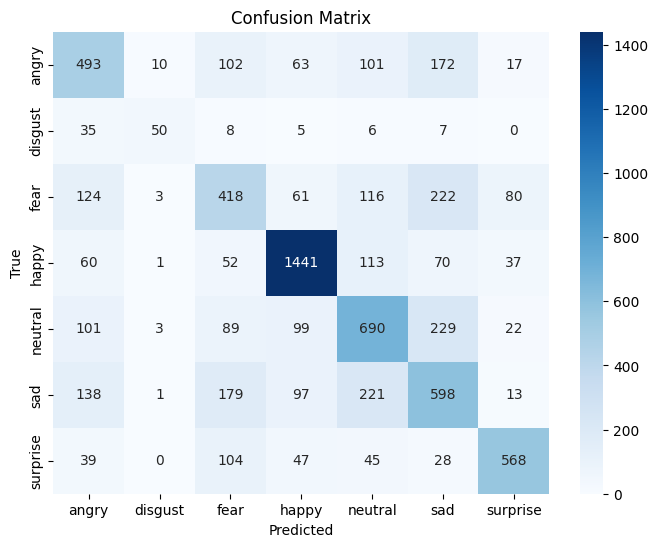

In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=emotion_labels,
    yticklabels=emotion_labels
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
#Save the model
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/emotion_cnn.pth")
print("Model saved successfully.")


Model saved successfully.


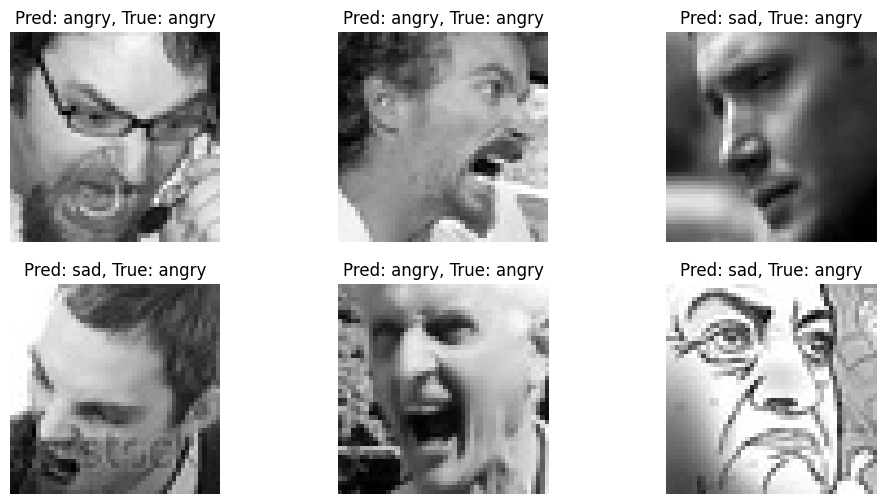

In [21]:
# VISUALIZE PREDICTIONS
def show_random_predictions(model, loader, num_images=6):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images[:num_images], labels[:num_images]
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img = images[i].squeeze().numpy()
        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Pred: {emotion_labels[int(preds[i])]}, True: {emotion_labels[int(labels[i])]}")
        plt.axis('off')
    plt.show()

show_random_predictions(model, test_loader)
